# Lab: Tree-Based Methods
We import some of our usual libraries at this top
level.

In [2]:
pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2e44b9f9a8b0872deba0ce3cb0c99034d26a84dabaf8969ca504e30a240ea212
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS


We also  collect the new imports
needed for this lab.

In [4]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART


Decision trees involve segmenting the predictor space into a number of simple regions $j$. In order to make a prediction for a given observation, we typically use the mean of the training observations in the region $j$ to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods.



## Fitting Classification Trees

We first use classification trees to analyze the  `Carseats`  data set.
In these data, `Sales` is a continuous variable, and so we begin
by recoding it as a binary variable. We use the `where()`
function to create a variable, called `High`, which takes on a
value of `Yes` if the `Sales` variable exceeds 8, and takes
on a value of `No` otherwise.

In [5]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")


We now use `DecisionTreeClassifier()`  to fit a classification tree in
order to predict `High` using all variables but `Sales`.
To do so, we must form a model matrix leaving `Sales` out.

In [6]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)


We have converted `D` from a data frame to an array `X`, which is needed in some of the analysis below. We also need the `feature_names` for annotating our plots later.

There are several options needed to specify the  classifier,
such as `max_depth` (how deep to grow the tree), `min_samples_split`
(minimum number of observations in a node to be eligible for splitting)
and `criterion` (whether to use Gini or cross-entropy as the split criterion).
We also set `random_state` for reproducibility; ties in the split criterion are broken at random.

In [7]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

There is a more
natural way to handle qualitative features when building a decision
tree, that does not require creating manually dummy variables; each split amounts to partitioning the levels into two groups.
However,
the `sklearn` implementation of decision trees does not take
advantage of this approach; instead it simply treats the one-hot-encoded levels as separate variables.

In [8]:
accuracy_score(High, clf.predict(X))


0.79

With only the default arguments, the training error rate is
21%.
For classification trees, we can
access the value of the deviance using `log_loss()`,
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the $m$th terminal
node that belong to the $k$th class.

In [9]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev


0.4710647062649358

A small deviance indicates atree that provides a good fit to the (training) data.

One of the most attractive properties of trees is that they can be graphically displayed. Here we use the `plot()`  function to display the tree structure.

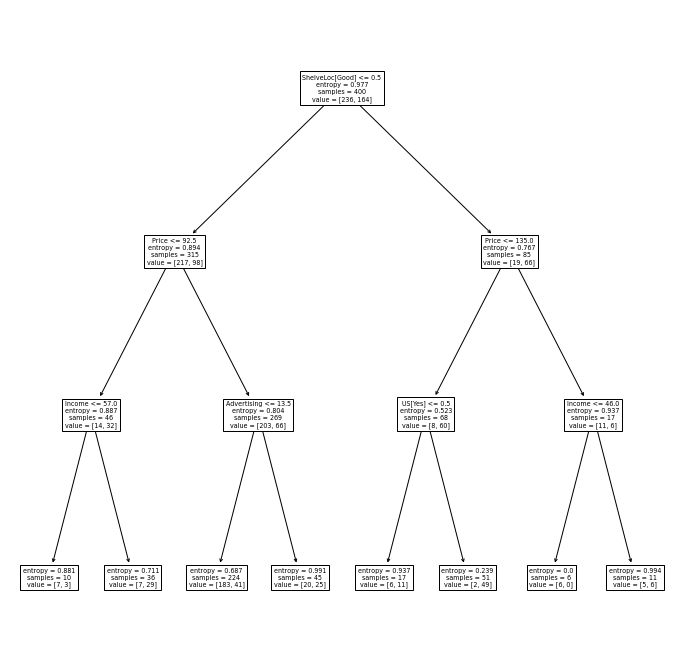

In [ ]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);


The most important indicator of `Sales` appears to be `ShelveLoc`.

We can see a text representation of the tree using
`export_text()`, which displays the split
criterion (e.g. `Price <= 92.5`) for each branch.
For leaf nodes it shows the overall prediction  
(`Yes` or `No`).
 We can also see the number of observations in that
leaf that take on values of `Yes` and `No` by specifying  `show_weights=True`.

In [ ]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))


|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In order to properly evaluate the performance of a classification tree
on these data, we must **estimate the test error** rather than simply
computing the training error.

To do so, we 1) split the observations into a training set and a test set; 2) build the tree using the training set; 3) and evaluate its performance on the test data. This approach leads to correct predictions
for 68.5% of the locations in the test data set.

In [10]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']


array([0.685])

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits might lead to lower variance and better interpretation at the cost of a little bias. We will prune this tree.

Next, we consider whether pruning the tree might lead to improved
classification performance. We first split the data into a training and
test set. We will use cross-validation to prune the tree on the training
set, and then evaluate the performance of the pruned tree on the test
set.

In [11]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)


We first refit the full tree on the training set; here we do not set a `max_depth` parameter, since we will learn that through cross-validation.


In [12]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))


0.735

Next we use the `cost_complexity_pruning_path()` method of
`clf` to extract cost-complexity values.

In [13]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)


This yields a set of impurities and $\alpha$ values
from which we can extract an optimal one by cross-validation.

In [14]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_


0.685

Let’s take a look at the pruned true.

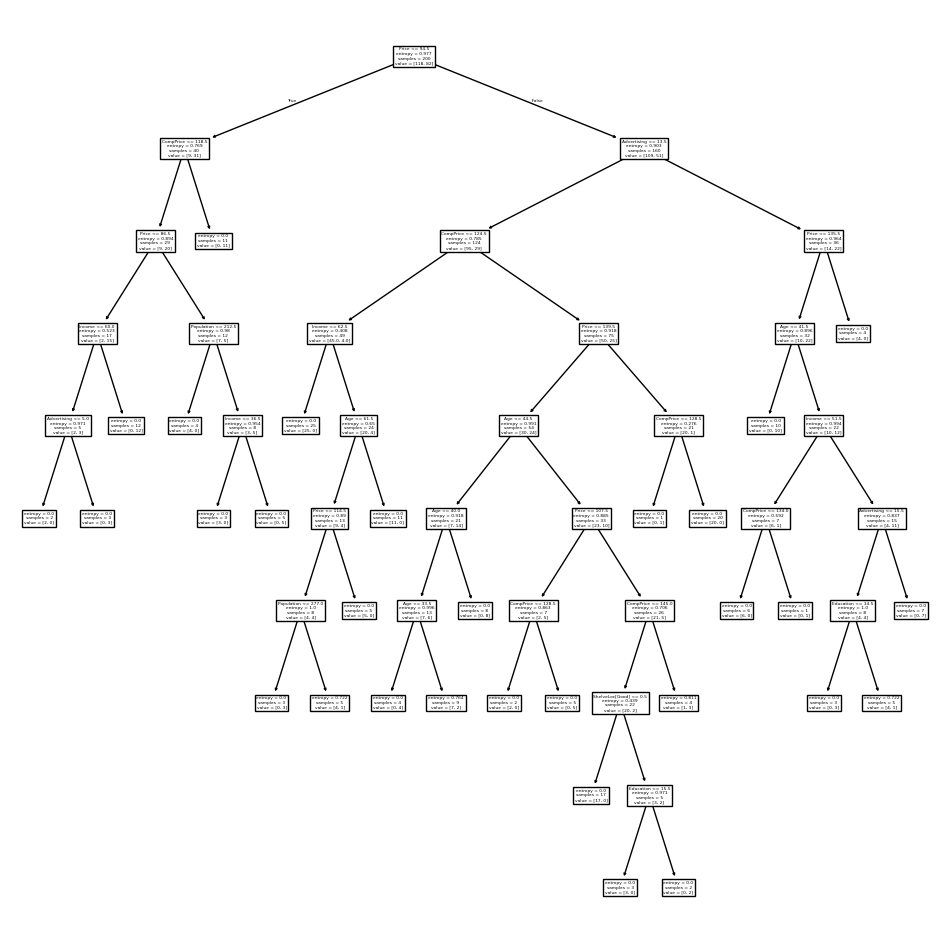

In [17]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);


This is quite a bushy tree. We could count the leaves, or query
`best_` instead.

In [18]:
best_.tree_.n_leaves


30

The tree with 30 terminal
nodes results in the lowest cross-validation error rate, with an accuracy of
68.5%. How well does this pruned tree perform on the test data set? Once
again, we apply the `predict()`  function.

In [19]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion


0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


Now 72.0% of the test observations are correctly classified, which is slightly worse than the error for the full tree (with 35 leaves). So cross-validation has not helped us much here; it only pruned off 5 leaves, at a cost of a slightly worse error. These results would change if we were to change the random number seeds above; even though cross-validation gives an unbiased approach to model selection, it does have variance.

  

## Fitting Regression Trees
For this session we will consider the  `Boston`  data set. As in past lab, it consists in individual level data of house in Boston metropolitan area. We are interested in predicting the houses `Median value` (Median value of owner-occupied homes in USD 1000s).

The steps are similar to those for classification trees.

In [32]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)


First, we split the data into training and test sets, and fit the tree to the training data. Here we use 30% of the data for the test set.

In [33]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)

Having formed our training and test data sets, we fit the regression tree.

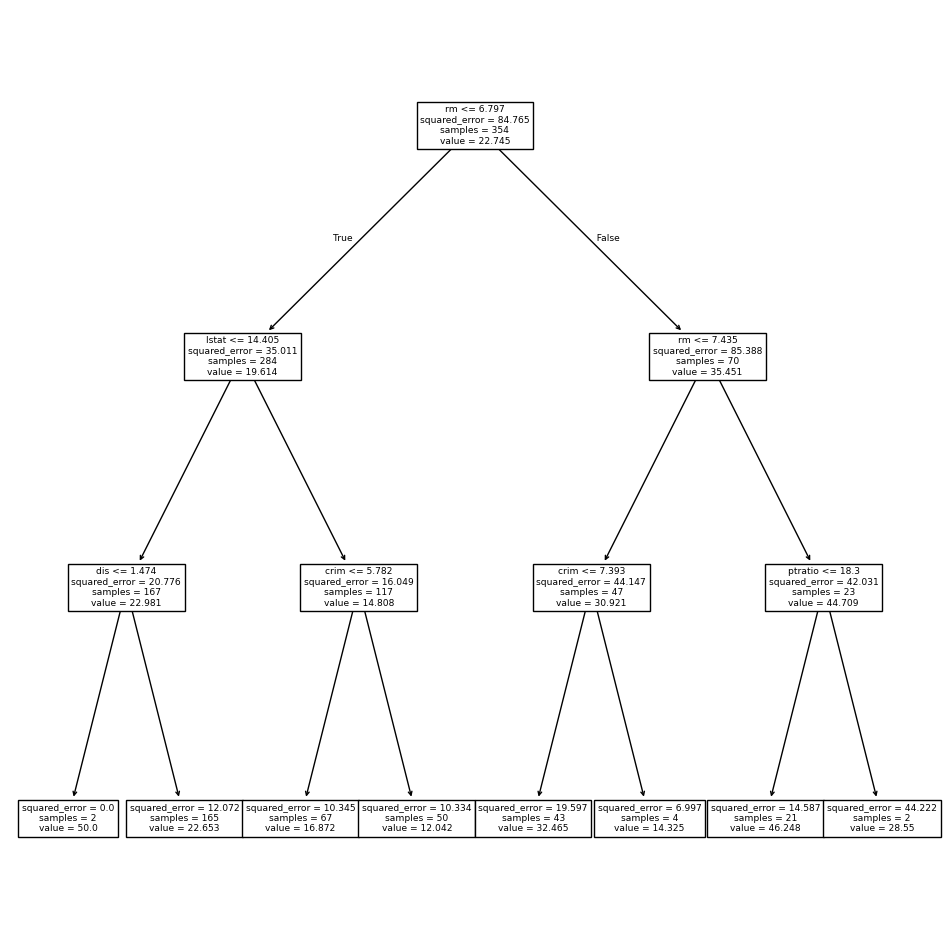

In [34]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

The variable `lstat` measures the percentage of individuals with lower socioeconomic status. The tree indicates that lower values of `lstat` correspond to more expensive houses. The tree predicts a median house price of $12,042 for small-sized homes (`rm` < 6.8), in suburbs in which residents have low socioeconomic status (`lstat`  > 14.4) and the crime-rate is moderate (`crim` > 5.8).

Now we use the cross-validation function to see whether pruning the tree will improve performance.

In [35]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In keeping with the cross-validation results, we use the pruned tree to make predictions on the test set.

In [36]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

In other words, the test set MSE associated with the regression tree is 28.07. The square root of the MSE is therefore around 5.30, indicating that this model leads to test predictions that are within around $5300 of the true median home value for the suburb.

Let’s plot the best tree to see how interpretable it is.

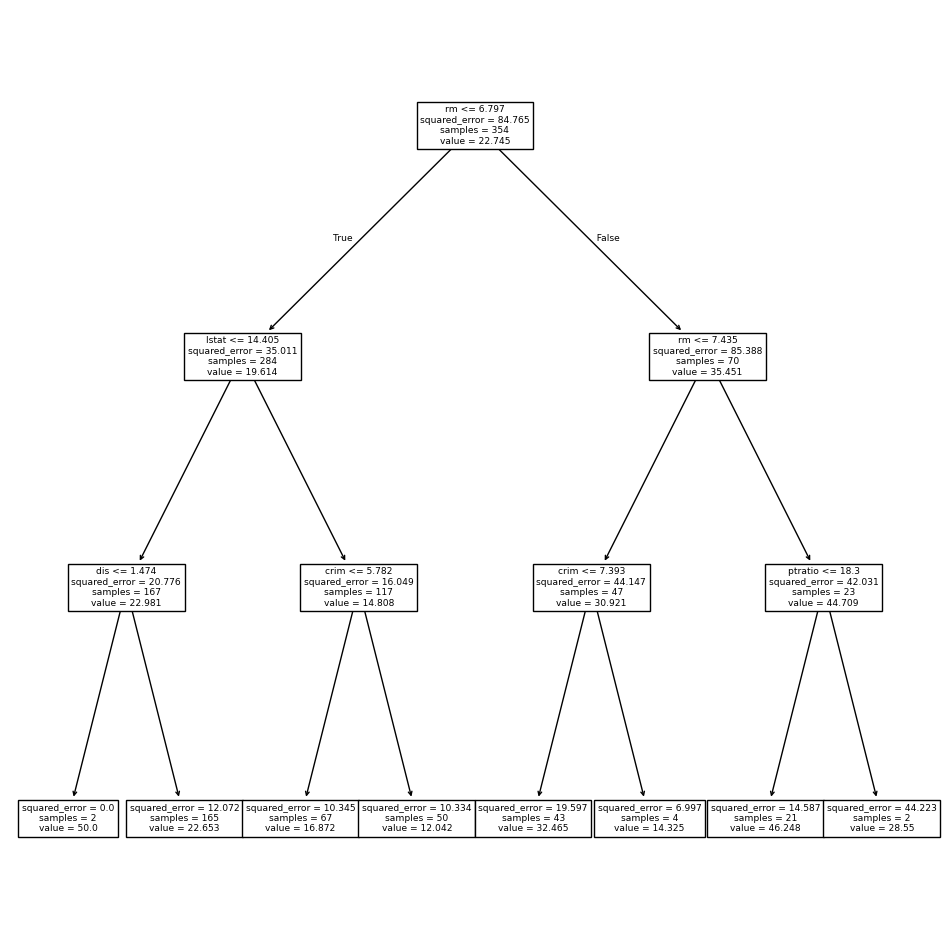

In [41]:
ax = subplots(figsize=(12,12))[1]
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

## Bagging and Random Forests

Bagging, random forests, and boosting use trees as building blocks to construct more powerful prediction models.

### Bagging

Remember the main problem of decision trees? It has high variance. Bootstrap aggregation, or bagging, reduce the variance of a statistical learning method.

The main intuition behind bagging is that averaging a set of random variables has lower variance than any single of them.

Indeed bagging consists in taking many boostrap sample from the population, build a separate prediction model using each training set $$  \hat{f_{bag}}(x) = \dfrac{1}{B}\sum_{b=1}^{B} \hat{f}^{*b}(x)$$  and average the resulting predictions.

We assess its performance using the **out-of-bag observations** ($\approx$ 1/3 of the sample) to predict $y$ for the $i^th$ observation using each of the trees in which it was OOB, yields to $B/3$ predictions for the $i^th$ obs. Then, we average each of them to compute the the out-of-bag error (i.e., test MSE).



Here we apply bagging and random forests to the `Boston` data, using
the `RandomForestRegressor()` from the `sklearn.ensemble` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `RandomForestRegressor()`  function can be used to
perform both bagging and random forests. We start with bagging.

In [39]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)


RandomForestRegressor(max_features=12, random_state=0)

The argument `max_features` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

14.634700151315787

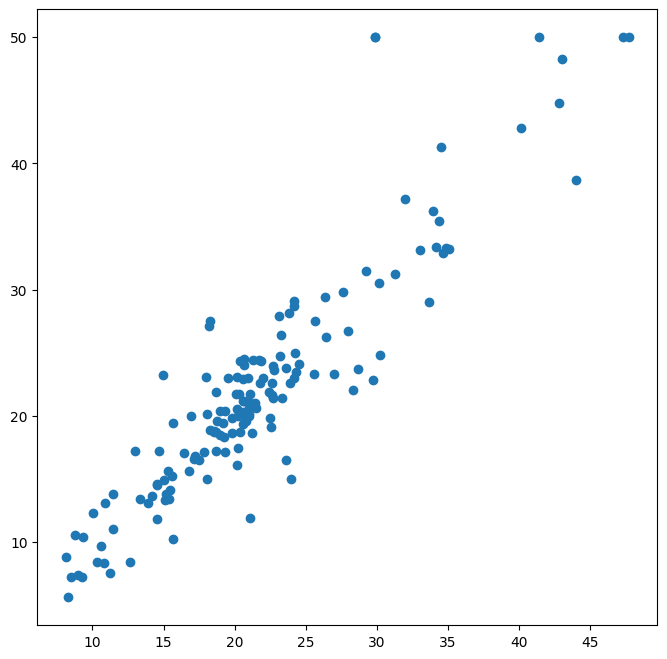

In [42]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)


The test set MSE associated with the bagged regression tree is
14.63, about half that obtained using an optimally-pruned single
tree.  We could change the number of trees grown from the default of
100 by
using the `n_estimators` argument:

In [ ]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.

#### Random forest

Random Forest: randomly restricts which splits of the tree are allowed at each node. At each split, only a random subsample of covariates $m$ is considered. Then, one covariate is chosen among $m$. A fresh sample is drawn at each split.

In growing a random forest, at each split in the tree, the algorithm is not even allowed to consider all the available predictors. Why? Suppose that there is one very strong covariate in the data set, along with a number of other moderately or weakly strong covariates. Then, most or all of the trees will use this strong predictor in the top split. Therefore, all of the bagged trees will look quite similar to each other and their predictions will be highly correlated. Why does it matter?

The reason is that averaging many highly correlated random variables does not lead to as large of a reduction in variance as averaging many uncorrelated random variables. This means that bagging will not lead to a substantial reduction in variance over a single tree in this setting.

Random forests overcome this problem: it forces **each split to consider only a subset of the predictors**.


Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `max_features` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `max_features=6`.

In [ ]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)


20.04276446710527

The test set MSE is 20.04;
this indicates that random forests did somewhat worse than bagging
in this case. Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [ ]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


We can have a look at the importance of each feature.

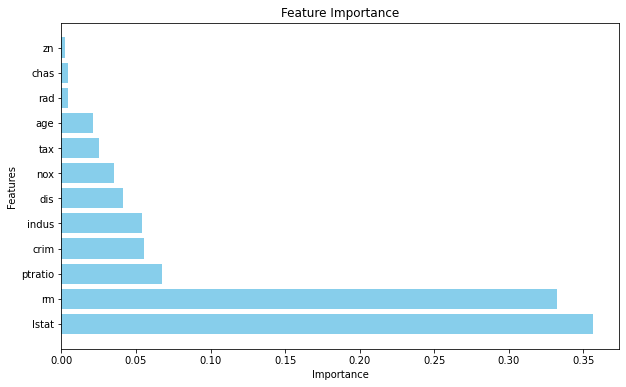

In [ ]:
# Sort the feature importance values in descending order
feature_imp_sorted = feature_imp.sort_values(by='importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_sorted.index, feature_imp_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees.

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

  

## Boosting

Boosting works similarly to bagging, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

Intuition is as follows:
 * Given the current model, we fit a decision tree to the residuals from the model: we fit a tree using the current residuals, rather than the outcome
, as the response.
 * Add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter  in the algorithm. By doing so, we slowly improve  in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down even further, allowing more and different shaped trees to shrink the residuals.
    
In general, statistical learning approaches that learn slowly tend to perform well.

Boosting has three tuning parameters:

1. The number of trees $B$
2. The shrinkage parameter $\lambda$: controls the rate at which boosting learns
3. The number of splits in each tree $d$: the complexity of the boosted ensemble.  Often $d = 1$ works well, in which case each tree is a stump, consisting of a single split.

Here we use `GradientBoostingRegressor()` from `sklearn.ensemble`
to fit boosted regression trees to the `Boston` data
set. For classification we would  use `GradientBoostingClassifier()`.
The argument `n_estimators=5000`
indicates that we want 5000 trees, and the option
`max_depth=3` limits the depth of each tree. The
argument `learning_rate` is the $\lambda$
mentioned earlier in the description of boosting.

In [43]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

We can see how the training error decreases with the `train_score_` attribute.
To get an idea of how the test error decreases we can use the
`staged_predict()` method to get the predicted values along the path.

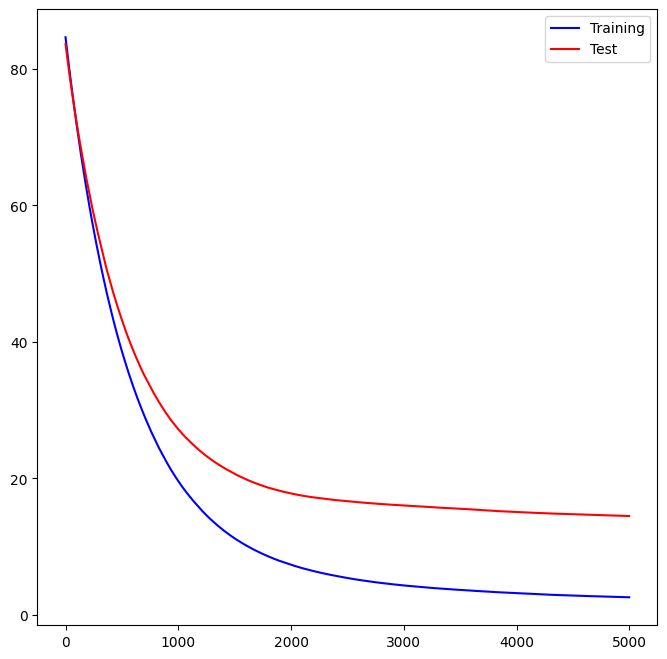

In [44]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();


We now use the boosted model to predict `medv` on the test set:

In [45]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.481405918831591

 The test MSE obtained is 14.48,
similar to the test MSE for bagging. If we want to, we can
perform boosting with a different value of the shrinkage parameter
$\lambda$. The default value is 0.001, but
this is easily modified.  Here we take $\lambda=0.2$.

In [46]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.501514553719565

In this case, using $\lambda=0.2$ leads to a almost the same test MSE
as when using $\lambda=0.001$.

